# Time series prediction

This is part of the work done by [Eric Parent](mailto:eric@eparent.info) for evaluating the application to an operations research developer at Air Transat.

In [1]:
import warnings
import itertools
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
plt.close('all')

In [3]:
start_date = dt.date(2018, 5, 1)
end_date = dt.date(2018, 10, 31)
nb_days = (end_date - start_date).days + 1

In [4]:
# Read data, use DepartureDate as index and have it already sorted by this index
data_df = pd.read_csv("../input/Data_test_Analytics.csv", parse_dates=['DepartureDate'])
# Read the routes info
route_info_df = pd.read_csv("../input/RouteInfo_test_Analytics.csv")

In [5]:
routes_df = pd.merge(data_df, route_info_df, on='Route', how='inner')

In [6]:
# Index by datetime on field "DepartureDate"
routes_df['DepartureDate'] = pd.to_datetime(routes_df['DepartureDate'])
# Add this field to the index
routes_df.index = routes_df['DepartureDate'].sort_index()

In [7]:
# Group the information by day so we have the daily information
routes_resampled = routes_df.resample("D").sum()
#routes_resampled = routes_df.groupby(routes_df['DepartureDate'].dt.strftime('%Y-%m-%d')).sum()
print(routes_resampled.head())
routes_resampled.to_csv("../input/Data_by_day.csv")


               FlightNumber  Hour  Capacity  Booked
DepartureDate                                      
2016-05-01             1944    46    1007.0   983.0
2016-05-02             1796    66    1470.0  1369.0
2016-05-03              697    57    1470.0  1433.0
2016-05-04              830    46    1000.0   980.0
2016-05-05             1560    61    1375.0  1320.0


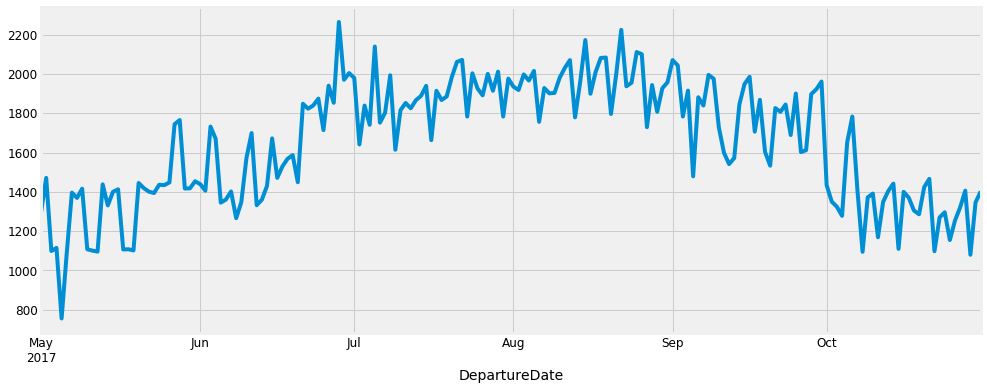

In [8]:
booking_2016 = routes_resampled["Booked"].loc["2016-05-01":"2016-10-31"]
booking_2017 = routes_resampled["Booked"].loc["2017-05-01":"2017-10-31"]
y = booking_2017
y.plot(figsize=(15, 6))
plt.show()

*Observations*:
- we see the seasonality is similar from year to year in terms of peaks but not in terms of amplitude; b

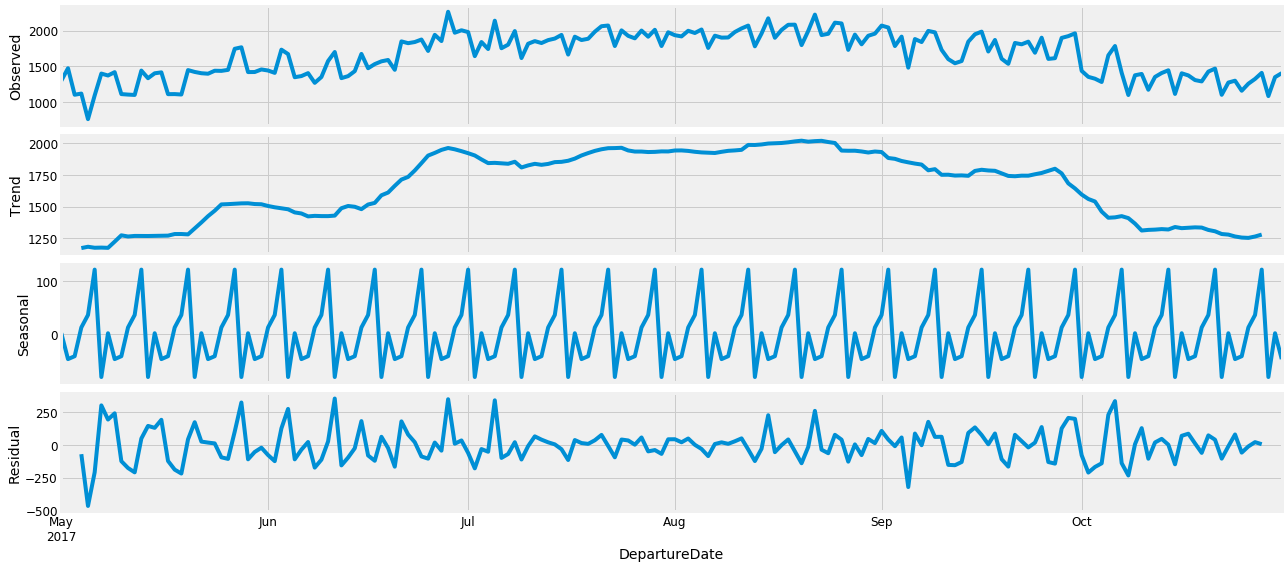

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Step 2 - parameters selection for the ARIMA time series model

In [10]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

print('PDQ : {}'.format(pdq))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
PDQ : [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [11]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

optimisation_results = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            #seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            optimisation_results[results.aic] = (param, param_seasonal)
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
min_value = min(optimisation_results.keys())
order, seasonal_order = optimisation_results[min_value]
print("Min value is {}: params {}".format(min_value, (order, seasonal_order)))

Min value is 2368.1214460592873: params ((1, 1, 1), (1, 1, 1, 12))


## Fitting an ARIMA time series model

In [12]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print("Type of results: {}".format(type(results)))
print(results.summary().tables[1])

Type of results: <class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2565      0.108      2.366      0.018       0.044       0.469
ma.L1         -0.7996      0.070    -11.366      0.000      -0.938      -0.662
ar.S.L12       0.0647      0.078      0.825      0.409      -0.089       0.218
ma.S.L12      -1.0000      0.119     -8.414      0.000      -1.233      -0.767
sigma2      2.724e+04   4.36e-06   6.24e+09      0.000    2.72e+04    2.72e+04


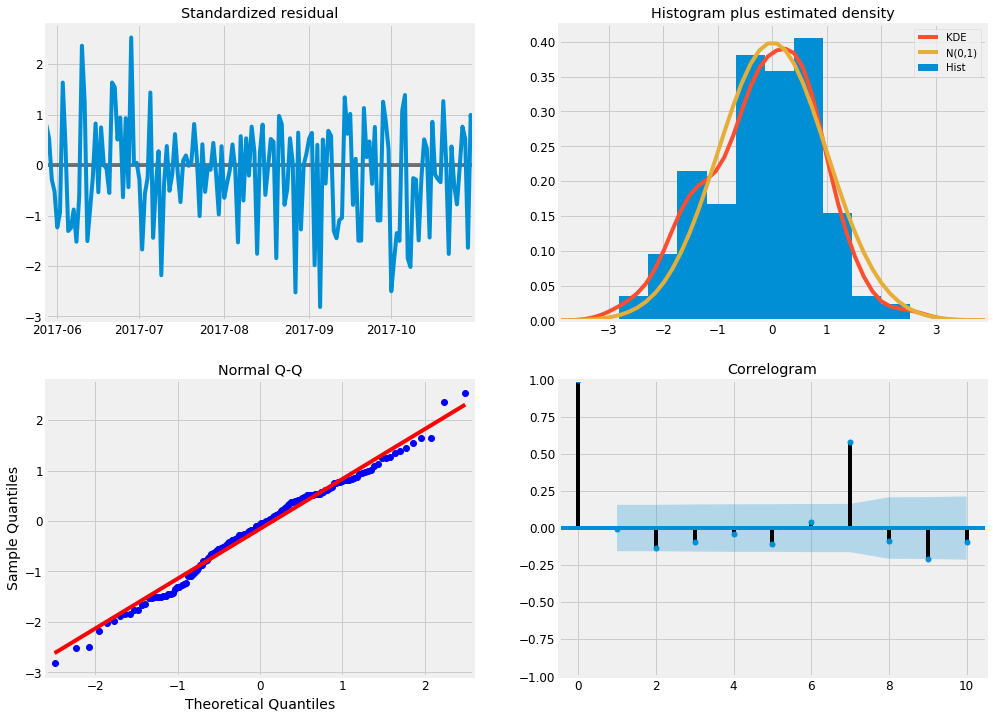

In [13]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Model validation

Let's validate our model with the predictions we have got for 2016.

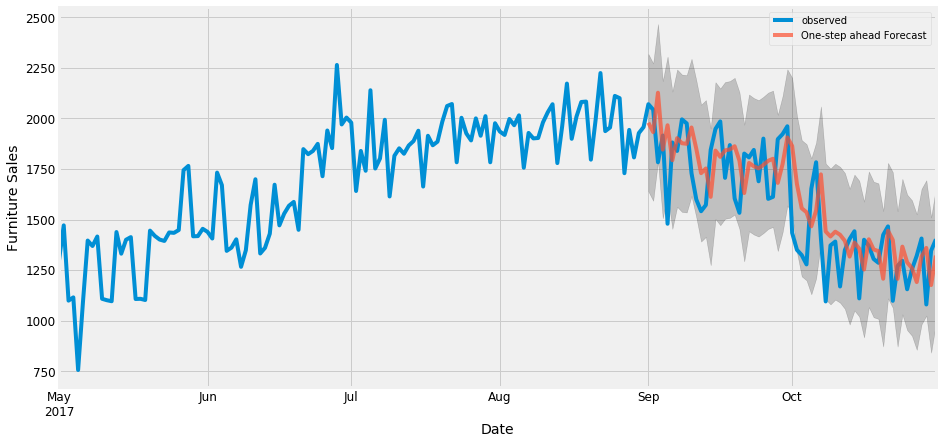

In [14]:
pred = results.get_prediction(start=pd.to_datetime('2017-09-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Compute MSE and RMSE and MAPE performance indicators

In [15]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
mape = ((np.abs(y_forecasted - y_truth) / y_truth).mean()) * 100.0
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean Absolute Percentage Error (MAPE) of our forecasts is {} %'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 36898.95
The Root Mean Squared Error of our forecasts is 192.09
The Mean Absolute Percentage Error (MAPE) of our forecasts is 10.84 %


# Forecast for same period of 2018
The forecast period is 2018-05-01 to 2018-10-31, inclusively.

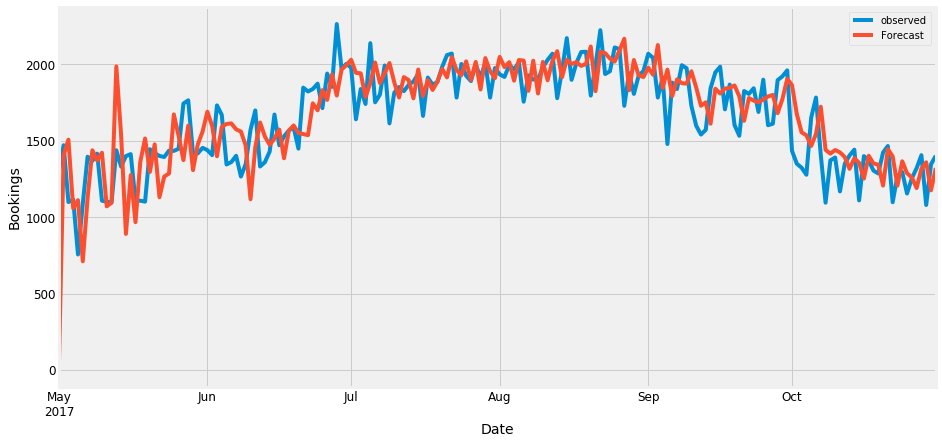

In [19]:
# VOIR CECI: https://stackoverflow.com/questions/38723825/forecasting-with-statsmodels
pred_2018 = results.get_prediction()
pred_ci = pred_2018.conf_int()

ax = y.plot(label="observed", figsize=(14,7))

pred_2018.predicted_mean.plot(ax=ax, label="Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Bookings")

plt.legend()
plt.show()

# Next steps

For some reason, the prediction calculations are falling flat.
Due to time constraints, the resolution of this issue has not been completed.
Investigations have been made but no solution was found.
It seems like it is a simple technical issue.

## Completed investigation steps

- Reading the `statsmodels` documentation
- Avoid having gaps in the timeline (between 2016-11-01 and 2017-04-20) by "stitching" data of active periods right after the other
- Searching for examples and tutorials (such as: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)